# Introduction

In this notebook we demonstrate the use of **LDA (Latent Dirichlet Allocation)** generative statistical model for Information Retrieval technique to make trace link recovery between Test Cases and Bug Reports.

We model our study as follows:

* Each bug report title, summary and description compose a single query.
* We use each test case content as an entire document that must be returned to the query made

# Import Libraries

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import pprint

from modules.models_runner.feat_br_models_runner import Feat_BR_Models_Runner
from modules.utils import aux_functions
from modules.utils import model_evaluator as m_eval
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import similarity_measures as sm
from modules.utils import br_feat_final_matrix_handler as b2f_handler

from matplotlib import pyplot as plt

import warnings; warnings.simplefilter('ignore')

# Load Datasets

In [2]:
bugreports = fd.Datasets.read_selected_bugreports_df()
features = fd.Datasets.read_features_df()

SelectedBugReports.shape: (91, 18)
Features.shape: (19, 8)


# Running LDA Model - Exp-Vol UNION Oracle

In [3]:
models_runner_1 = Feat_BR_Models_Runner()

lda_model_1 = models_runner_1.run_lda_model()

evaluator_1 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_union_df().T)

sim_thresh = 0.0

lda_eval_t1 = evaluator_1.evaluate_model(model=lda_model_1, top_value=1, sim_threshold=sim_thresh)
lda_eval_t3 = evaluator_1.evaluate_model(model=lda_model_1, top_value=3, sim_threshold=sim_thresh)
lda_eval_t5 = evaluator_1.evaluate_model(model=lda_model_1, top_value=5, sim_threshold=sim_thresh)
lda_eval_t10 = evaluator_1.evaluate_model(model=lda_model_1, top_value=10, sim_threshold=sim_thresh)

Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LDA model -----
Expert and Volunteers Matrix UNION.shape: (91, 19)


# Similarity Matrix

In [4]:
aux_functions.highlight_df(lda_model_1.get_sim_matrix().iloc[0:23, 0:14])

Bug_Number,1248267,1248268,1257087,1264988,1267480,1267501,1269348,1269485,1270274,1270983,1271607,1276120,1277937,1278388
feat_name,,,,,,,,,,,,,,
new_awesome_bar,0.869301,0.888931,0.975643,0.881123,0.998607,0.875559,0.90984,0.839666,0.920443,0.956969,0.919589,0.943305,0.829907,0.983194
windows_child_mode,0.374227,0.470457,0.381045,0.592159,0.304086,0.365985,0.651904,0.469116,0.445174,0.291605,0.387905,0.410405,0.774572,0.297015
apz_async_scrolling,0.605183,0.542775,0.351547,0.460792,0.169583,0.592869,0.253994,0.613068,0.489581,0.437938,0.51491,0.449837,0.18987,0.336451
browser_customization,0.871522,0.890772,0.976685,0.883323,0.999394,0.877622,0.911624,0.842155,0.922491,0.95838,0.921547,0.944681,0.83184,0.984088
pdf_viewer,0.304652,0.226546,0.246359,0.227388,0.255031,0.324366,0.233429,0.299995,0.238464,0.245555,0.26536,0.264658,0.252806,0.248866
context_menu,0.788344,0.736991,0.581066,0.661534,0.417935,0.778352,0.478888,0.789624,0.695861,0.654857,0.718061,0.664044,0.401204,0.567729
w10_comp,0.869828,0.889373,0.975907,0.881646,0.998813,0.87605,0.910269,0.840253,0.920933,0.957315,0.920058,0.943643,0.830368,0.983424
tts_in_desktop,0.248741,0.25152,0.274268,0.251939,0.283716,0.272255,0.25903,0.264581,0.264228,0.272713,0.2632,0.26512,0.235476,0.277065
tts_in_rm,0.240972,0.243538,0.265432,0.244061,0.274658,0.240618,0.250857,0.232676,0.255982,0.264082,0.254953,0.256603,0.228041,0.26815


# Analysis of BR x Feat Generated Traces

In [5]:
handler = b2f_handler.BR_Feat_Final_Matrix_Handler(mode=b2f_handler.HandlerMode.LOAD)
br_2_features_matrix_final = handler.add_mappings_1(columns_names=['Features_IDs_lda_t1_m',
                                                                   'Features_IDs_lda_t3_m',
                                                                   'Features_IDs_lda_t5_m',
                                                                   'Features_IDs_lda_t10_m',
                                                                   'Features_IDs_orc'],
                                                    trace_matrices=[lda_eval_t1['trace_links_df'],
                                                                    lda_eval_t3['trace_links_df'],
                                                                    lda_eval_t5['trace_links_df'],
                                                                    lda_eval_t10['trace_links_df'],
                                                                    evaluator_1.get_oracle_df()],
                                                    is_from_model=True)

br_2_features_matrix_final = handler.add_mappings_2(dest_columns_names=['f_names_lda_t1',
                                                                        'f_names_lda_t3',
                                                                        'f_names_lda_t5',
                                                                        'f_names_lda_t10',
                                                                        'f_names_orc'],
                                                   orig_columns_names=['Features_IDs_lda_t1_m',
                                                                       'Features_IDs_lda_t3_m',
                                                                       'Features_IDs_lda_t5_m',
                                                                       'Features_IDs_lda_t10_m',
                                                                       'Features_IDs_orc'])
br_2_features_matrix_final.head(10)

SelectedBugReports.shape: (91, 18)
Features.shape: (19, 8)
BR_2_Features Matrix Final.shape: (91, 5)


,bug_title,Features_IDs_exp_m,Features_IDs_vol_m,Features_IDs_exp_vol_union_m,Features_IDs_exp_vol_intersec_m,Features_IDs_lda_t1_m,Features_IDs_lda_t3_m,Features_IDs_lda_t5_m,Features_IDs_lda_t10_m,Features_IDs_orc,f_names_lda_t1,f_names_lda_t3,f_names_lda_t5,f_names_lda_t10,f_names_orc
Bug_Number,,,,,,,,,,,,,,,
1248267,"Right click on bookmark item of ""Recently Book...",6,6,6,6,4,4 10 18,1 4 7 10 18,1 2 3 4 6 7 10 11 12 18,6,[[browser_customization]],"[[browser_customization], [webgl_comp], [indic...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [windows_child_mode], [apz...",[[context_menu]]
1248268,"Unable to disable ""Recently bookmarked""",,4,4,,4,4 10 18,1 4 7 10 18,1 2 3 4 6 7 10 11 12 18,4,[[browser_customization]],"[[browser_customization], [webgl_comp], [indic...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [windows_child_mode], [apz...",[[browser_customization]]
1257087,Middle mouse click on history item would not open,,,,,4,4 10 18,1 4 7 10 18,1 2 4 6 7 10 11 12 14 18,,[[browser_customization]],"[[browser_customization], [webgl_comp], [indic...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [windows_child_mode], [bro...",[]
1264988,Scrollbar appears for a moment in the new Awes...,1,1,1,1,4,4 10 18,1 4 7 10 18,1 2 4 6 7 10 12 15 18 19,1,[[browser_customization]],"[[browser_customization], [webgl_comp], [indic...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [windows_child_mode], [bro...",[[new_awesome_bar]]
1267480,Intermittent browser/components/preferences/in...,,,,,4,4 10 18,1 4 7 10 18,1 4 6 7 10 11 12 14 16 18,,[[browser_customization]],"[[browser_customization], [webgl_comp], [indic...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [...",[]
1267501,New Private Browsing start-page overflows off ...,3,,3,,4,4 10 18,1 4 7 10 18,1 2 3 4 6 7 10 11 12 18,3,[[browser_customization]],"[[browser_customization], [webgl_comp], [indic...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [windows_child_mode], [apz...",[[apz_async_scrolling]]
1269348,Show last sync date tooltip on Synced Tabs sid...,,,,,4,4 10 18,1 4 7 10 18,1 2 4 6 7 10 12 15 18 19,,[[browser_customization]],"[[browser_customization], [webgl_comp], [indic...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [windows_child_mode], [bro...",[]
1269485,New Private Browsing start-page has white/gray...,3,,3,,4,4 10 18,1 4 7 10 18,1 2 3 4 6 7 10 11 12 18,3,[[browser_customization]],"[[browser_customization], [webgl_comp], [indic...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [windows_child_mode], [apz...",[[apz_async_scrolling]]
1270274,Intermittent browser_share.jsuncaught exceptio...,,,,,4,4 10 18,1 4 7 10 18,1 2 3 4 6 7 10 11 12 18,,[[browser_customization]],"[[browser_customization], [webgl_comp], [indic...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [windows_child_mode], [apz...",[]


# Analysis of Precision and Recall

## Union Strategy

Evaluating LDA Model ----- 


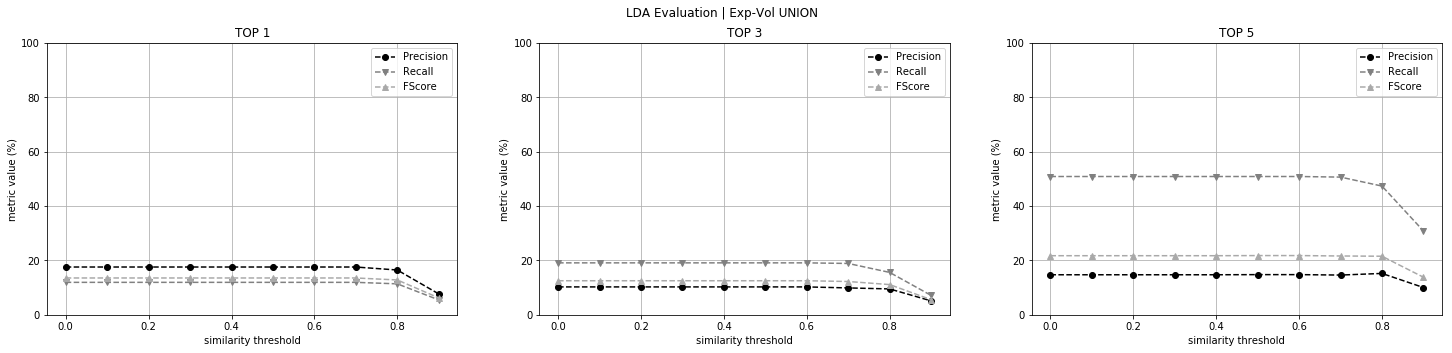

In [6]:
results_1 = evaluator_1.run_evaluator(models=[lda_model_1], top_values=[1,3,5], sim_thresholds=[(sm.SimilarityMeasure.COSINE, s_thresh/10) for s_thresh in range(0,10)])
evaluator_1.plot_evaluations_2(title='LDA Evaluation | Exp-Vol UNION', results=results_1)

## Intersection Strategy

Expert and Volunteers Matrix INTERSEC.shape: (91, 19)
Evaluating LDA Model ----- 


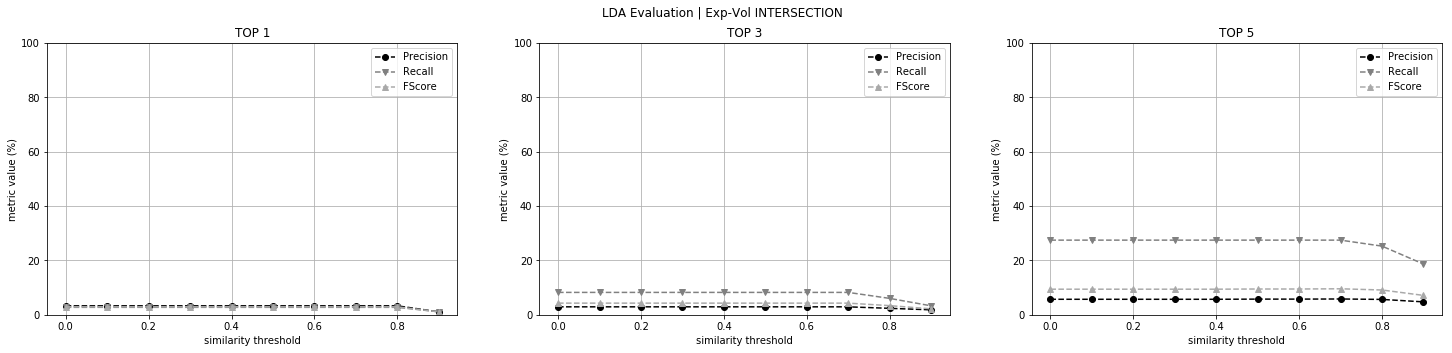

In [7]:
evaluator_2 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_intersec_df().T)
results_2 = evaluator_2.run_evaluator(models=[lda_model_1], top_values=[1,3,5], sim_thresholds=[(sm.SimilarityMeasure.COSINE, s_thresh/10) for s_thresh in range(0,10)])
evaluator_2.plot_evaluations_2(title='LDA Evaluation | Exp-Vol INTERSECTION', results=results_2)

## Expert-Only Strategy

Feat_BR Expert Matrix shape: (91, 19)
Evaluating LDA Model ----- 


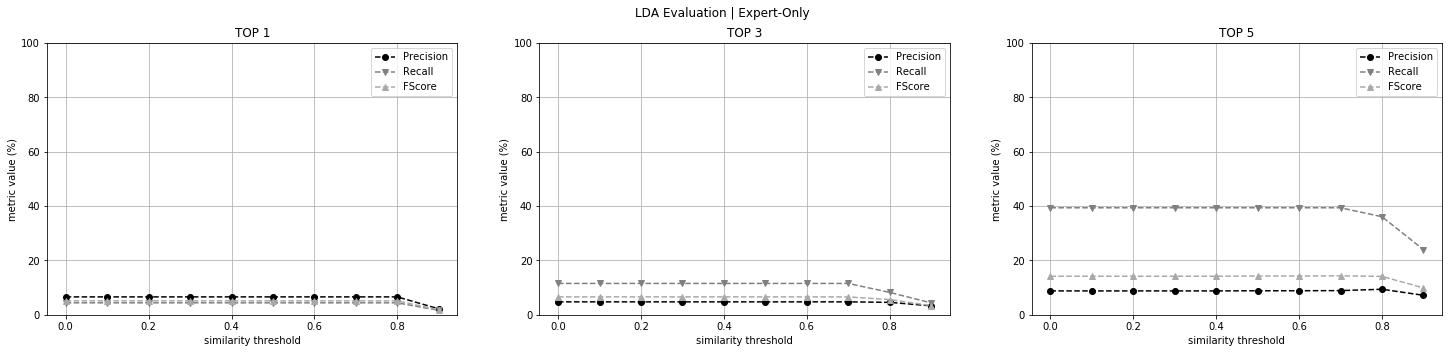

In [8]:
evaluator_3 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_df().T)
results_3 = evaluator_3.run_evaluator(models=[lda_model_1], top_values=[1,3,5], sim_thresholds=[(sm.SimilarityMeasure.COSINE, s_thresh/10) for s_thresh in range(0,10)])
evaluator_3.plot_evaluations_2(title='LDA Evaluation | Expert-Only', results=results_3)

## Volunteers-Only Strategy

Feat_BR Volunteers Matrix shape: (91, 19)
Evaluating LDA Model ----- 


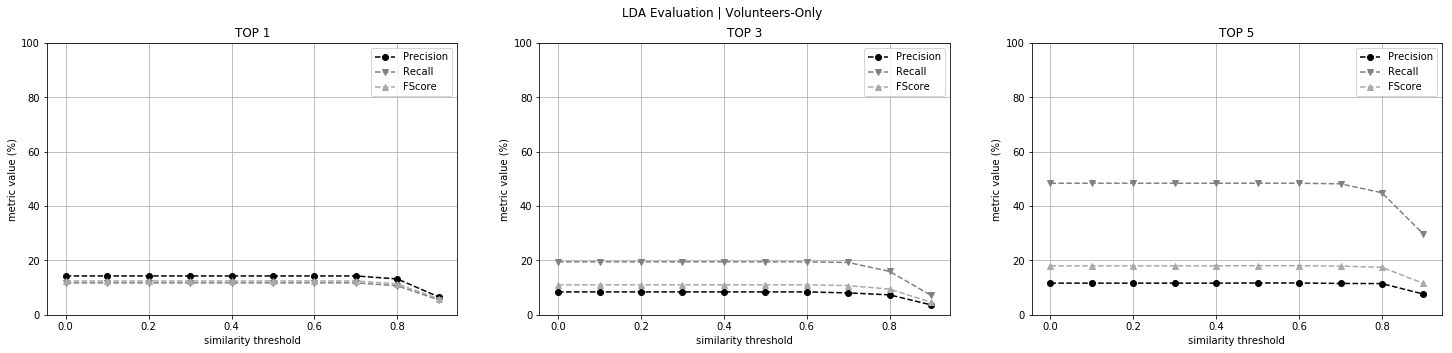

In [9]:
evaluator_4 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_volunteers_df().T)
results_4 = evaluator_4.run_evaluator(models=[lda_model_1], top_values=[1,3,5], sim_thresholds=[(sm.SimilarityMeasure.COSINE, s_thresh/10) for s_thresh in range(0,10)])
evaluator_4.plot_evaluations_2(title='LDA Evaluation | Volunteers-Only', results=results_4)

# Analysis of False Positives

# Analysis of False Negatives